# Project 1
- 2) Tìm hiểu bài toán phân loại văn bản đa nhãn Multi-label classification và các phương pháp giải quyết nó, tức là 1 input có thể thuộc về nhiều nhãn 

## Lib

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize

import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Snape\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Snape\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from wordcloud import WordCloud
from ast import literal_eval
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse as sp_sparse

In [3]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [5]:
from sklearn.metrics import roc_curve, auc
# from scipy import interp
from itertools import cycle

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

#for visualisation
import yellowbrick
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.text import TSNEVisualizer

## Read File

In [8]:
# train_path ="data/predict_tag/"
train_path = ""

In [9]:
train_df = pd.read_csv(train_path + "train_p2.csv")
# test_df = pd.read_csv(test_path)

## Overiview data
- Create 'CONTEXT' column
- Drop
- check NA

In [13]:
train_df.head()

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,CONTEXT
0,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps. ...
1,1,0,0,0,0,0,Rotation Invariance Neural Network. Rotation...
2,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...
3,0,0,1,0,0,0,A finite element approximation for the stochas...
4,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...


In [10]:
# combining 'title' and 'abstract' column to| get more context
train_df['CONTEXT'] = train_df['TITLE'] + ". " + train_df['ABSTRACT']



In [11]:

# dropping useless features/columns
train_df.drop(labels=['TITLE', 'ABSTRACT', 'ID'], axis=1, inplace=True)

In [14]:
train_df.columns


Index(['Computer Science', 'Physics', 'Mathematics', 'Statistics',
       'Quantitative Biology', 'Quantitative Finance', 'CONTEXT'],
      dtype='object')

In [15]:
# rearranging columns
train_df = train_df[['CONTEXT', 'Computer Science', 'Physics', 'Mathematics', 'Statistics',
                     'Quantitative Biology', 'Quantitative Finance',]]
     

In [16]:
train_df.isna().sum()

CONTEXT                 0
Computer Science        0
Physics                 0
Mathematics             0
Statistics              0
Quantitative Biology    0
Quantitative Finance    0
dtype: int64

In [17]:
train_df.head()

,CONTEXT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,Reconstructing Subject-Specific Effect Maps. ...,1,0,0,0,0,0
1,Rotation Invariance Neural Network. Rotation...,1,0,0,0,0,0
2,Spherical polyharmonics and Poisson kernels fo...,0,0,1,0,0,0
3,A finite element approximation for the stochas...,0,0,1,0,0,0
4,Comparative study of Discrete Wavelet Transfor...,1,0,0,1,0,0


In [18]:
target_cols = ['Computer Science', 'Physics', 'Mathematics', 'Statistics',
       'Quantitative Biology', 'Quantitative Finance']
X = train_df['CONTEXT']
y = train_df[target_cols]
y

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,1,0,0,1,0,0
...,...,...,...,...,...,...
20967,1,1,0,0,0,0
20968,0,1,0,0,0,0
20969,1,0,0,0,0,0
20970,0,0,1,1,0,0


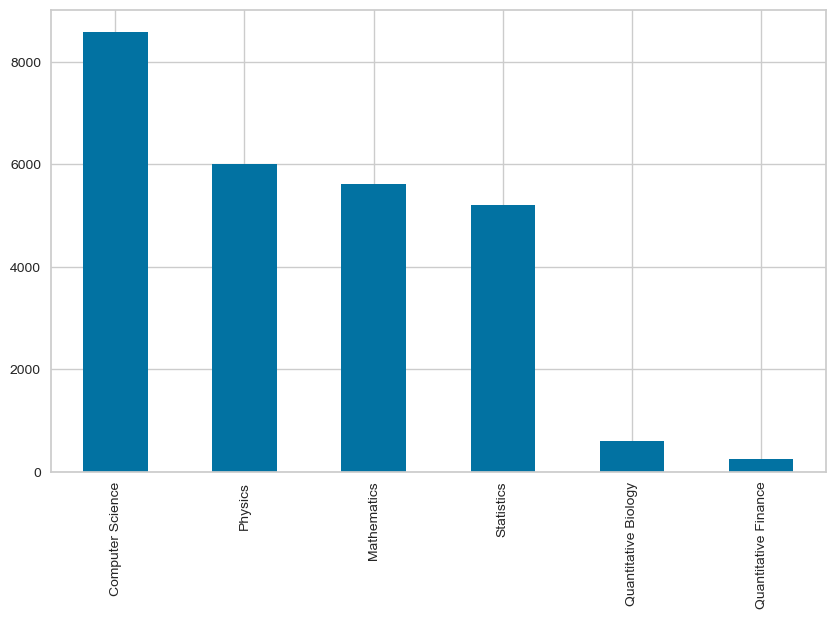

In [19]:
y_data_target = train_df[target_cols]

# Plot category data
plt.figure(figsize=(10,6))
y_data_target.sum(axis=0).plot.bar()
plt.show()

In [23]:
train_df['Count'] = y.astype(bool).sum(axis=1)
train_df['Count']


C:\Users\Snape\AppData\Local\Temp\ipykernel_24020\133613147.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Count'] = y.astype(bool).sum(axis=1)


0        1
1        1
2        1
3        1
4        2
        ..
20967    2
20968    1
20969    1
20970    2
20971    2
Name: Count, Length: 20972, dtype: int64

In [28]:
count_values = train_df['Count'].value_counts().sort_index()
count_values


Count
1    15928
2     4793
3      251
Name: count, dtype: int64

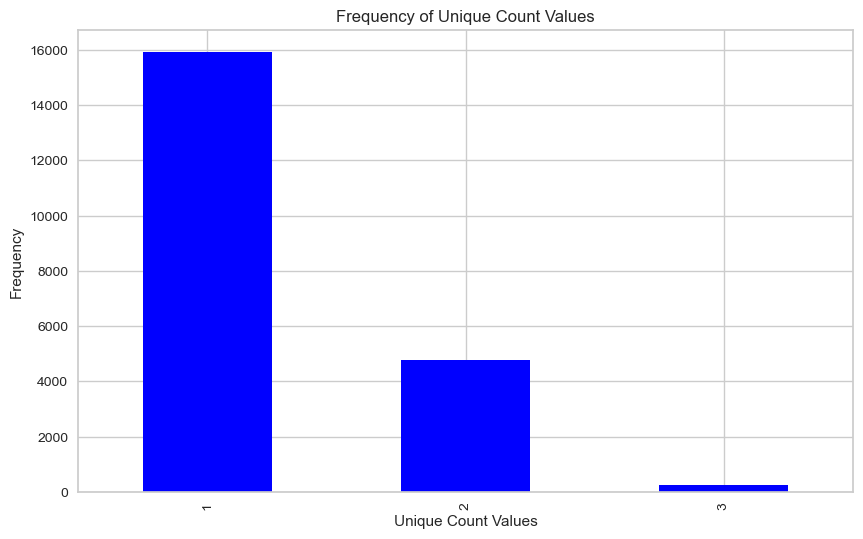

In [27]:
plt.figure(figsize=(10, 6))
count_values.plot(kind='bar', color='blue')
plt.xlabel('Unique Count Values')
plt.ylabel('Frequency')
plt.title('Frequency of Unique Count Values')
plt.show()

## Split data

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, test_size= .25)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(15729,)
(5243,)
(15729, 6)
(5243, 6)


In [17]:
X_train[:3]

2132     Partial and Total Dielectronic Recombination R...
9243     The Multiple Roots Phenomenon in Maximum Likel...
13444    Control Variates for Stochastic Gradient MCMC....
Name: CONTEXT, dtype: object

In [18]:
y_train

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
2132,0,1,0,0,0,0
9243,0,0,1,1,0,0
13444,1,0,0,1,0,0
15347,0,0,0,0,1,0
18566,1,0,0,0,0,0
...,...,...,...,...,...,...
11284,0,0,0,1,0,0
11964,0,1,0,0,0,0
5390,0,1,0,0,0,0
860,1,0,0,0,0,0


## Visual

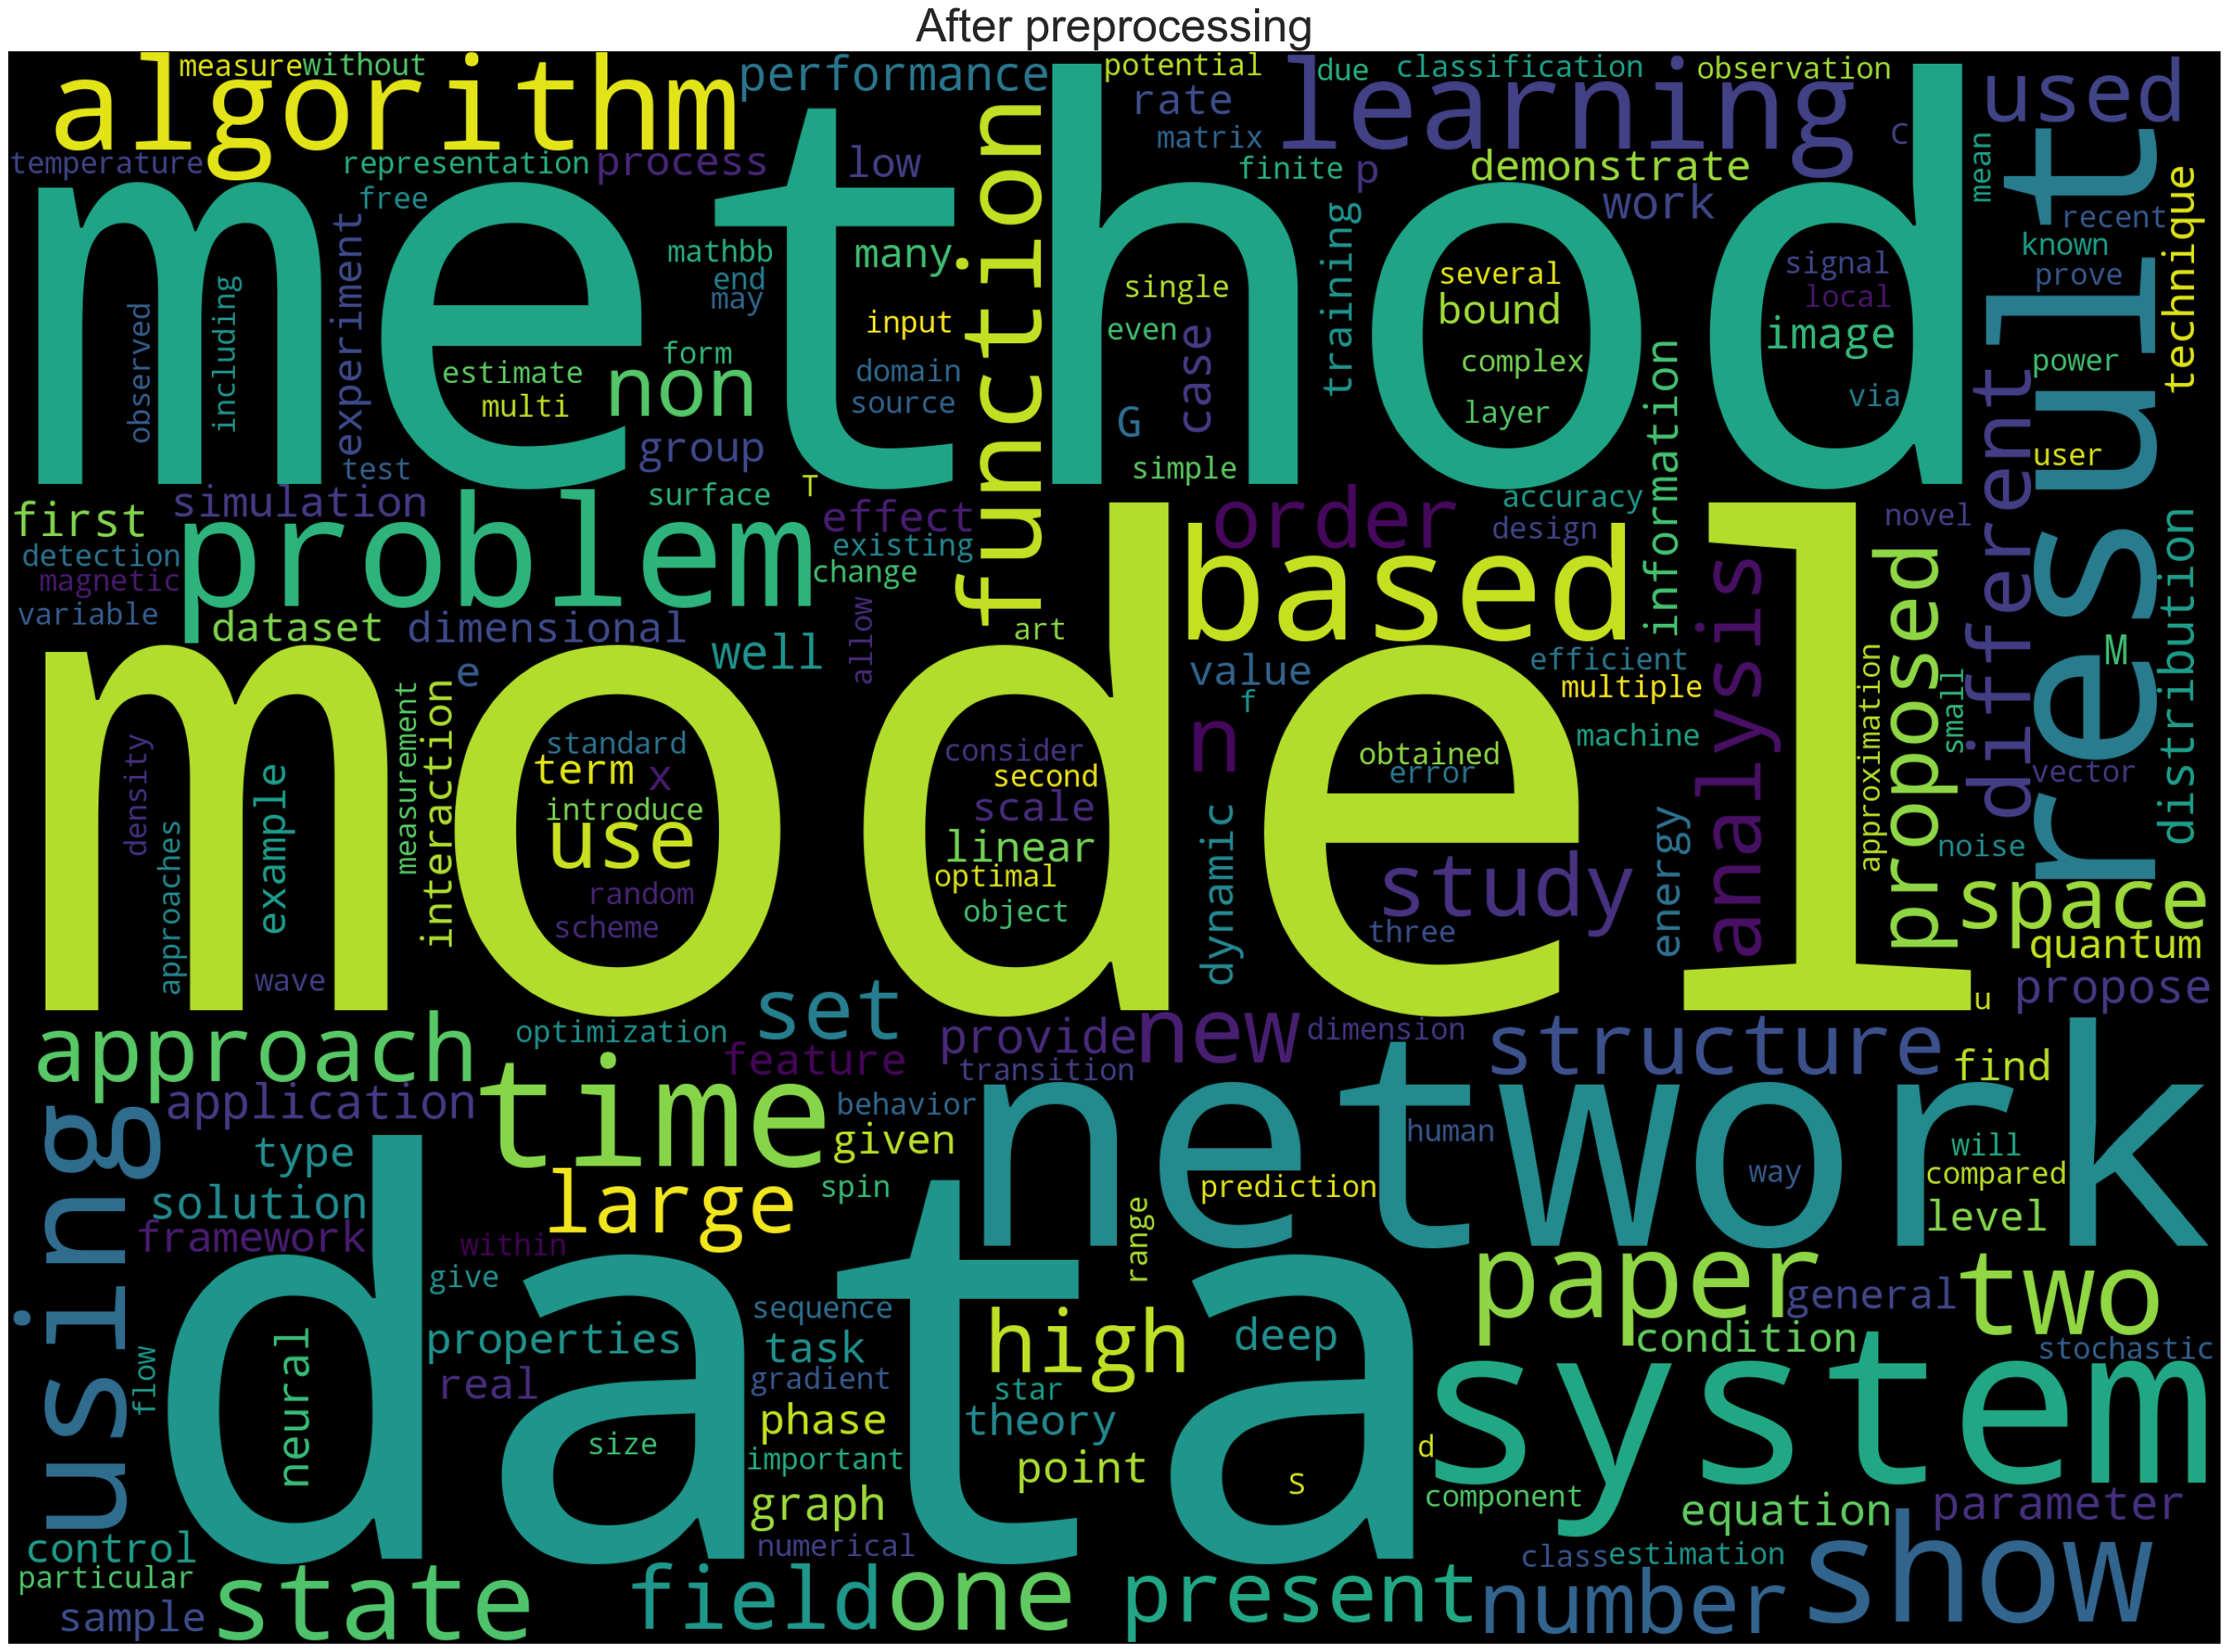

In [19]:
#Before preprocessing

from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(40,25))
# clean

text = X_train
cloud_comp = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))
plt.axis('off')
plt.title("After preprocessing",fontsize=40)
plt.imshow(cloud_comp)

### Preprocessing

In [20]:
# Regular expressions for cleaning text
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')  # Remove characters in this set with a space
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')           # Remove any character that is not alphanumeric or a space
STOPWORDS = set(stopwords.words('english'))            # Set of English stopwords

# Function to prepare text data
def text_prepare(text):
    text = text.lower()                                # Convert text to lowercase
    text = re.sub(REPLACE_BY_SPACE_RE, ' ', text)      # Replace specified characters with a space
    text = re.sub(BAD_SYMBOLS_RE, '', text)            # Remove symbols not allowed
    token_words = word_tokenize(text)                  # Tokenize the text into words
    filtered_words = [word for word in token_words if word not in STOPWORDS]  # Remove stopwords
    text = ''
    for word in filtered_words:                       
        if word != filtered_words[len(filtered_words)-1]:  # If not the last word, add a space after the word
            text = text + word + ' '
        else:                                          # If it's the last word, don't add a space after it
            text = text + word
    return text  # Return the cleaned text


In [21]:
X_train = [text_prepare(x) for x in X_train]
X_test = [text_prepare(x) for x in X_test]

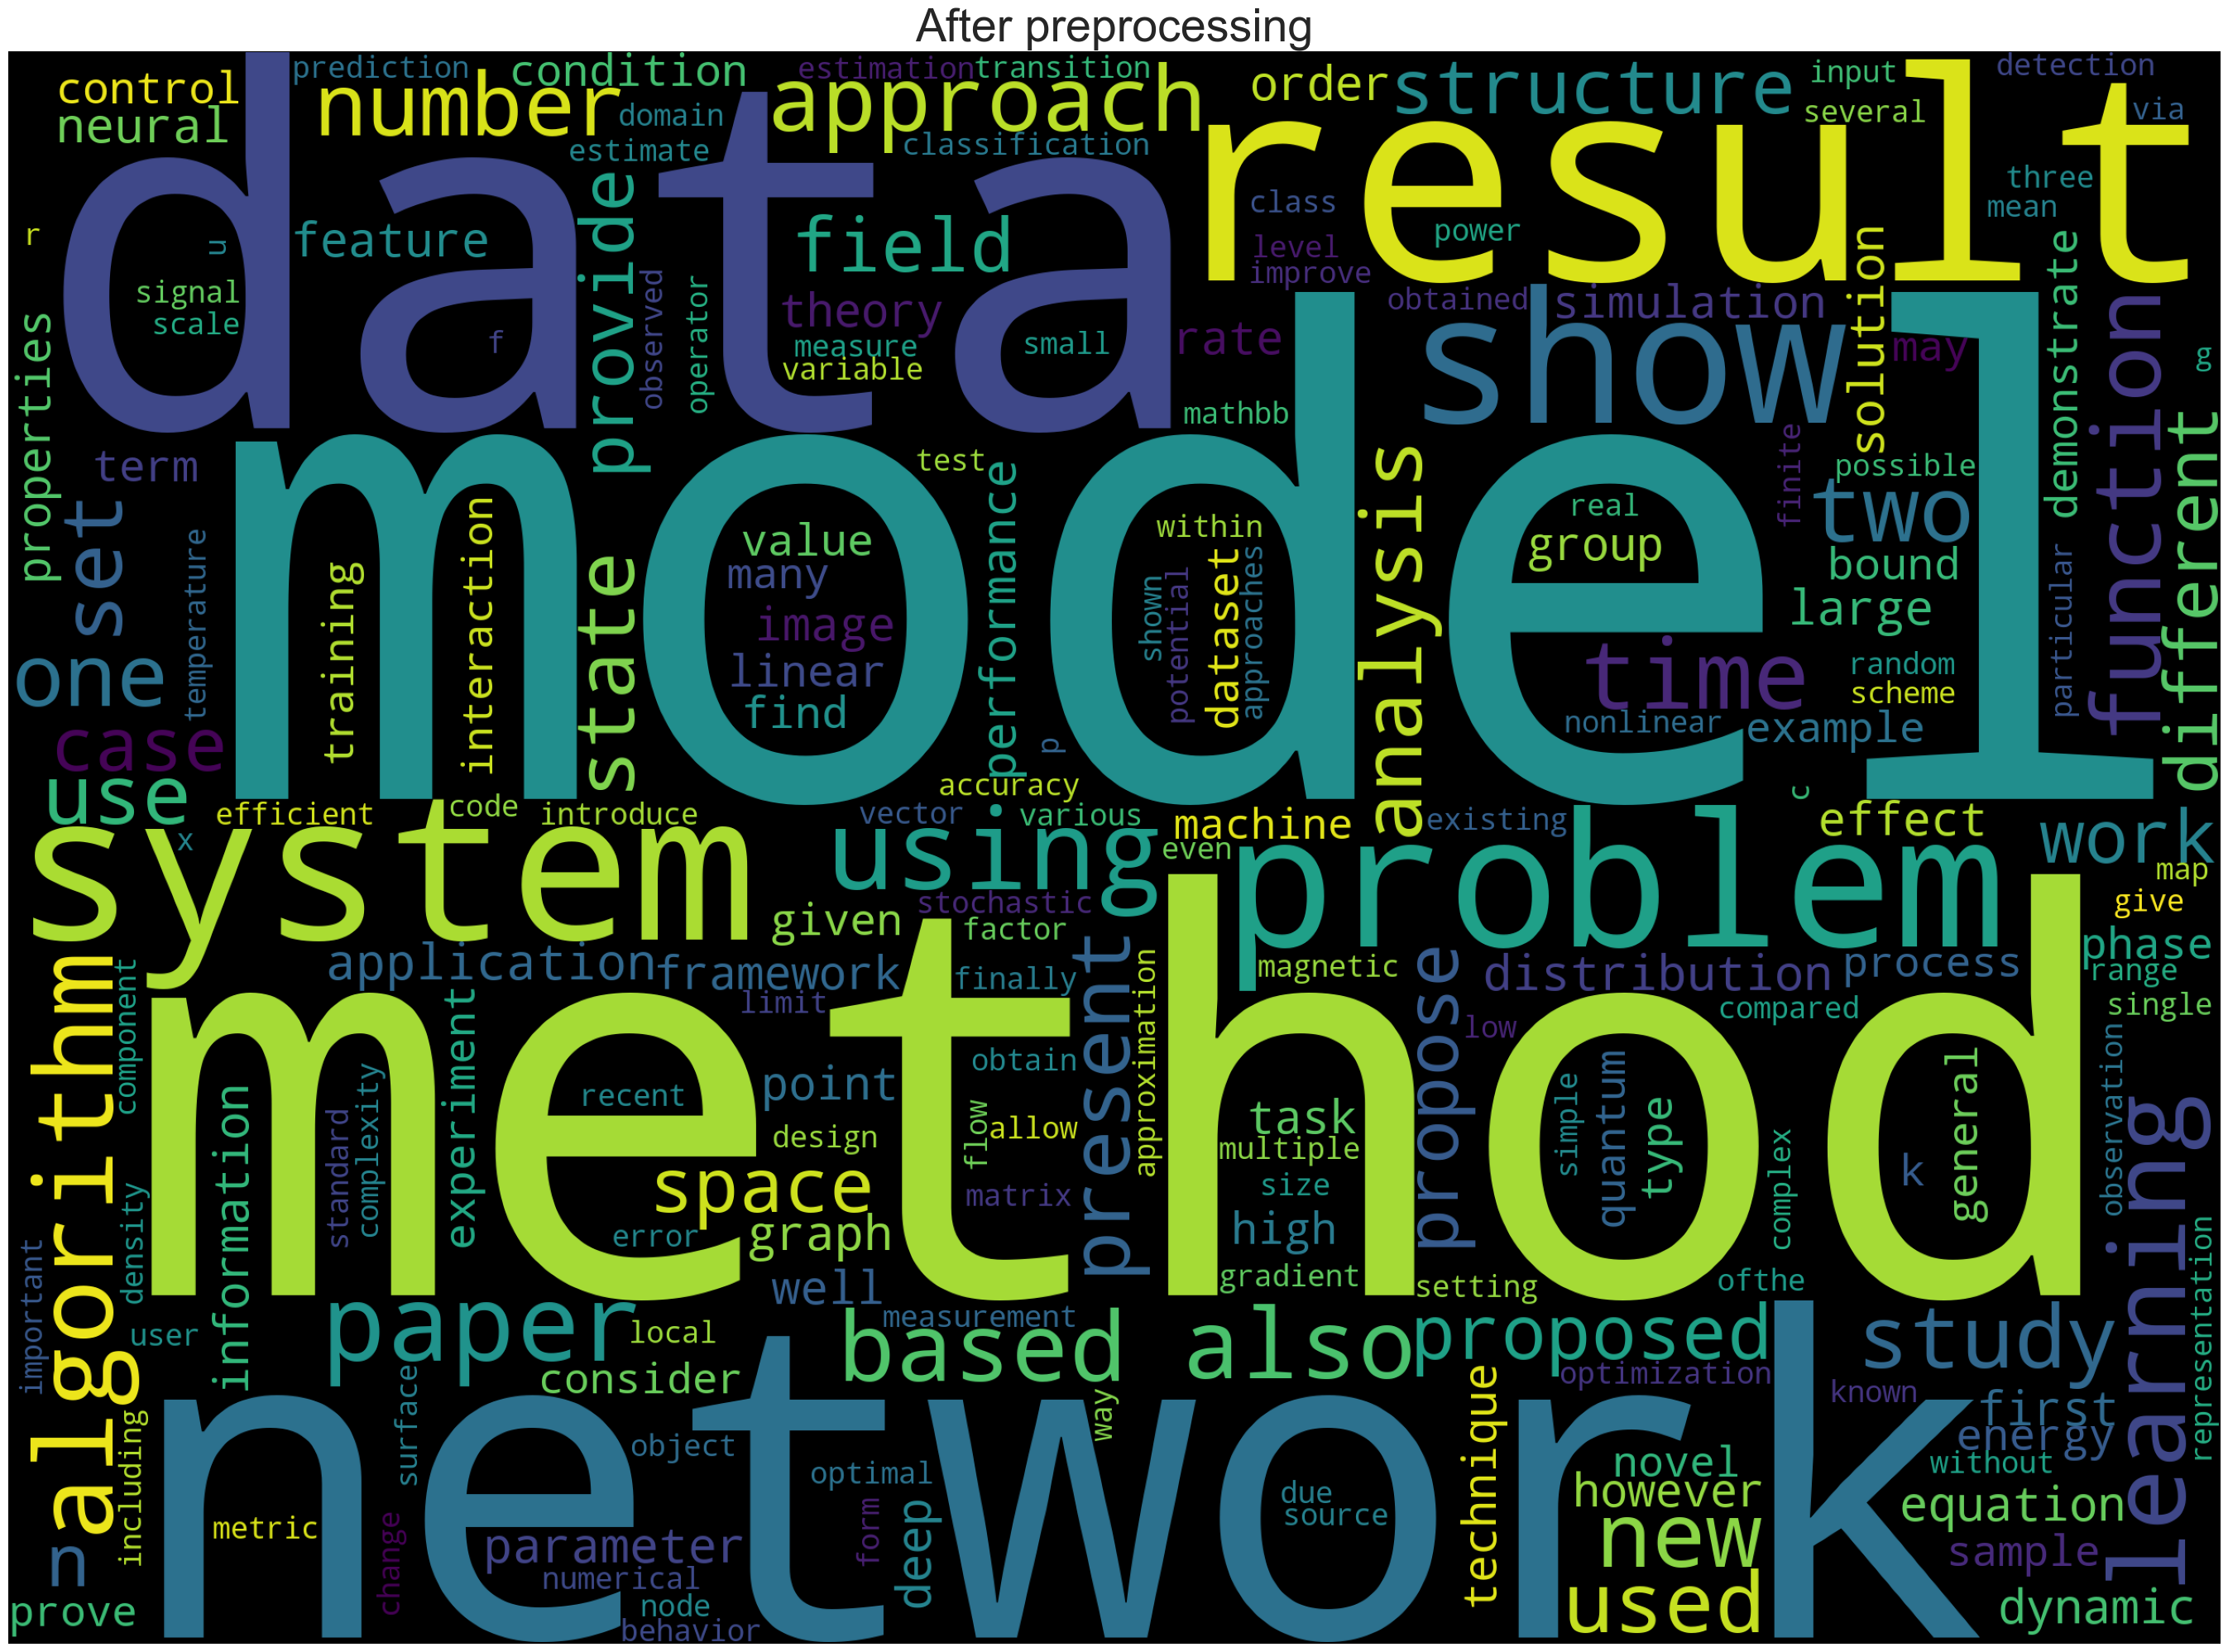

In [22]:
plt.figure(figsize=(40,25))
# clean

text = X_train
cloud_comp = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))
plt.axis('off')
plt.title("After preprocessing",fontsize=40)
plt.imshow(cloud_comp)

### TF-IDF
- considering the overall word frequencies within the corpora. This aids in penalizing overly common words and creates an improved feature space.

In [23]:
# Initialize a TfidfVectorizer with specific parameters
# strip_accents='unicode': Remove accents and perform unicode normalization
# analyzer='word': Analyze text data at the word level
# norm='l2': Apply L2 normalization to the term frequencies

vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', norm='l2')
vectorizer.fit(X_train)
vectorizer.fit(X_test)

TfidfVectorizer(strip_accents='unicode')

In [24]:
# Fit on the training data and transform both training and test data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [25]:
# vectorizer.__dict__

In [26]:
feature_names = vectorizer.get_feature_names_out()

In [27]:
feature_names

array(['00', '000', '00000029', ..., 'zynqsystemonchip', 'zz', 'zz_2'],
      dtype=object)

In [28]:
idfs = vectorizer.idf_

In [29]:
# print(sorted(idfs))

In [30]:
fi = dict()
for i in range(len(feature_names)):
  fi[feature_names[i]] = idfs[i]

In [ ]:
# print(vectorizer.vocabulary_)

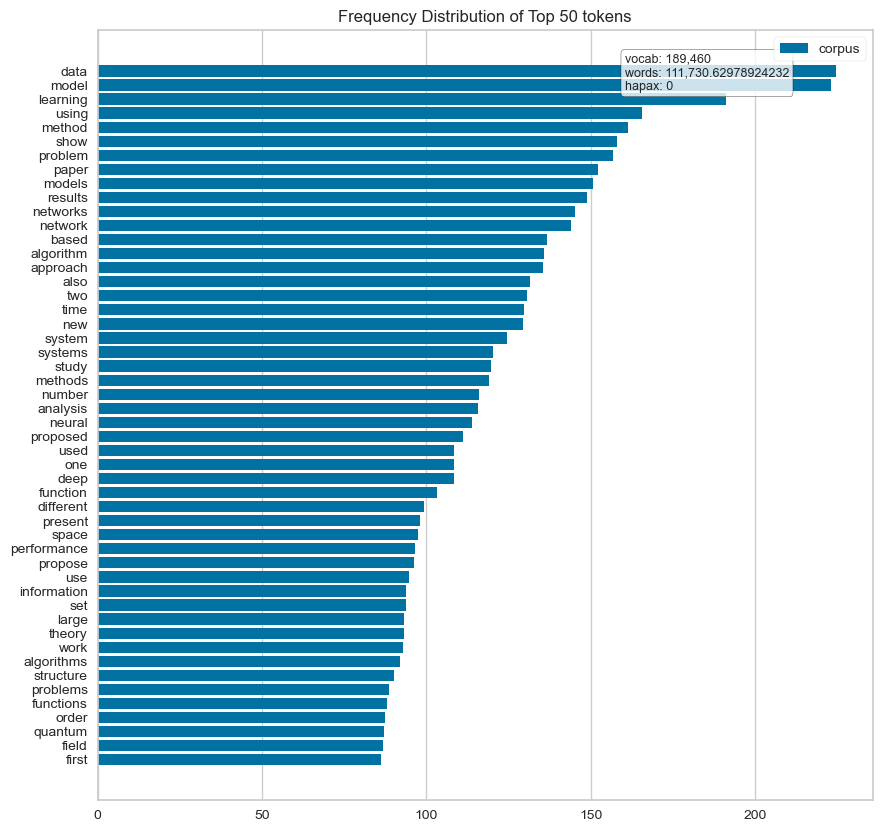

<Axes: title={'center': 'Frequency Distribution of Top 50 tokens'}>

In [32]:
# Create a FreqDistVisualizer object to visualize word frequency
# features=feature_names: Use the list of feature names (words) learned from TfidfVectorizer
visualizer = FreqDistVisualizer(features=feature_names,size=(1000, 1000))
visualizer.fit(X_train_tfidf)
visualizer.poof()

In [33]:
categories = y_train.keys()
len(categories)

6

In [35]:
X_train_tfidf, y_train

(<15729x189460 sparse matrix of type '<class 'numpy.float64'>'
 	with 1150877 stored elements in Compressed Sparse Row format>,
        Computer Science  Physics  Mathematics  Statistics  \
 2132                  0        1            0           0   
 9243                  0        0            1           1   
 13444                 1        0            0           1   
 15347                 0        0            0           0   
 18566                 1        0            0           0   
 ...                 ...      ...          ...         ...   
 11284                 0        0            0           1   
 11964                 0        1            0           0   
 5390                  0        1            0           0   
 860                   1        0            0           0   
 15795                 1        0            0           0   
 
        Quantitative Biology  Quantitative Finance  
 2132                      0                     0  
 9243               

### Train and test

In [36]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

## Technique to solve this problem:
- Problem Transformation: Binary Relevance, Classifier Chains, Label Powerset
- Adapted Algorithm
- Ensemble approaches
- Neural Network

In [39]:
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import TruncatedSVD

from joblib import dump, load

#### Reduce dimension


In [40]:
svd = TruncatedSVD(n_components=1000)  # Adjust n_components as needed
X_train_tfidf_reduced = svd.fit_transform(X_train_tfidf)
X_test_tfidf_reduced = svd.transform(X_test_tfidf)

In [41]:
print(X_train_tfidf_reduced.shape)
print(X_test_tfidf_reduced.shape)

(15729, 1000)
(5243, 1000)


### Binary Relevance
- Classifier: GaussianNB

In [43]:
type(X_test)

list

In [44]:
Accuracy_BR = []

In [45]:
# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(classifier = GaussianNB())
# train
classifier.fit(X_train_tfidf_reduced, y_train)
# predict
predictions = classifier.predict(X_test_tfidf_reduced)
# accuracy
result_BR_NB = accuracy_score(y_test,predictions)
Accuracy_BR.append(result_BR_NB)
print("Accuracy = ", result_BR_NB)

Accuracy =  0.23097463284379172


- Classifier: SVM

In [46]:
# > 48m
# initialize Binary Relevance multi-label classifier
# with an SVM classifier
# SVM in scikit only supports the X matrix in sparse representation

# classifier = BinaryRelevance(
#     classifier = SVC(),
#     require_dense = [False, True]
# )

# # train
# classifier.fit(X_train_tfidf_reduced, y_train)

# # predict
# predictions = classifier.predict(X_test_tfidf_reduced)

# print("Accuracy = ",accuracy_score(y_test,predictions))

In [47]:
# save the model
# dump(classifier, 'classifier_BR_SVM.joblib') 

In [48]:
classifier_BR_SVM = load('classifier_BR_SVM.joblib')
predictions_BR_SVM = classifier_BR_SVM.predict(X_test_tfidf_reduced)

result_BR_SVM = accuracy_score(y_test,predictions_BR_SVM)
Accuracy_BR.append(result_BR_SVM)
print("Accuracy = ", result_BR_SVM)

Accuracy =  0.6566851039481213


- Classifier: Logistic Regression

In [49]:
classifier_brlr = BinaryRelevance(classifier = LogisticRegression())

# train
classifier_brlr.fit(X_train_tfidf_reduced, y_train)

# predict
predictions = classifier_brlr.predict(X_test_tfidf_reduced)

result_BR_LR = accuracy_score(y_test,predictions)
Accuracy_BR.append(result_BR_LR)
print("Accuracy = ", result_BR_LR)

Accuracy =  0.633034522220103


- Classifier: Random Forest

In [50]:
# initialize BinaryRelevance multi-label classifier with a RandomForest
classifier = BinaryRelevance(
    classifier = RandomForestClassifier(n_estimators=100),
    require_dense = [False, True]
)

# train
classifier.fit(X_train_tfidf_reduced, y_train)

# predict
predictions = classifier.predict(X_test_tfidf_reduced)

result_BR_RF = accuracy_score(y_test,predictions)
Accuracy_BR.append(result_BR_RF)
print("Accuracy = ", result_BR_RF) 

Accuracy =  0.5363341598321572


In [51]:
# save the model
dump(classifier, 'classifier_BR_RF.joblib') 

['classifier_BR_RF.joblib']

### Classifier Chain

- GaussianNB

In [52]:
Accuracy_CC = []

In [53]:
# initialize classifier chains multi-label classifier
# with a gaussian naive bayes base classifier
classifier = ClassifierChain(GaussianNB())

# train
classifier.fit(X_train_tfidf_reduced, y_train)

# predict
predictions = classifier.predict(X_test_tfidf_reduced)

result_CC_NB = accuracy_score(y_test,predictions)
Accuracy_CC.append(result_CC_NB)
print("Accuracy = ", result_CC_NB) 


Accuracy =  0.3154682433721152


In [54]:
# initialize classifier chains multi-label classifier
# with an SVM classifier
# SVM in scikit only supports the X matrix in sparse representation

# classifier = ClassifierChain(
#     classifier = SVC(),
#     require_dense = [False, True]
# )

# # train
# classifier.fit(X_train_tfidf_reduced, y_train)

# # predict
# predictions = classifier.predict(X_test_tfidf_reduced)

# result_CC_SVM = accuracy_score(y_test,predictions)
# Accuracy_CC.append(result_CC_SVM)
# print("Accuracy = ", result_CC_SVM) 

In [55]:
# save the model
# dump(classifier, 'classifier_CC_SVM.joblib') 

In [56]:
classifier_CC_SVM = load('classifier_CC_SVM.joblib')
predictions_CC_SVM = classifier_CC_SVM.predict(X_test_tfidf_reduced)

result_CC_SVM = accuracy_score(y_test,predictions_CC_SVM)
Accuracy_CC.append(result_CC_SVM)
print("Accuracy = ", result_CC_SVM)

Accuracy =  0.38413122258249094


In [57]:
# initialize classifier chains multi-label classifier
classifier = ClassifierChain(LogisticRegression())
# Training logistic regression model on train data
classifier.fit(X_train_tfidf_reduced, y_train)
# predict
predictions = classifier.predict(X_test_tfidf_reduced)

# accuracy
result_CC_LR = accuracy_score(y_test,predictions)
Accuracy_CC.append(result_CC_LR)
print("Accuracy = ", result_CC_LR) 

Accuracy =  0.6658401678428381


In [58]:
# initialize Classifier Chain multi-label classifier with a RandomForest
classifier = ClassifierChain(
    classifier = RandomForestClassifier(n_estimators=100),
    require_dense = [False, True]
)

# train
classifier.fit(X_train_tfidf_reduced, y_train)

# predict
predictions = classifier.predict(X_test_tfidf_reduced)

result_CC_RF = accuracy_score(y_test,predictions)
Accuracy_CC.append(result_CC_RF)
print("Accuracy = ", result_CC_RF) 

Accuracy =  0.5681861529658593


In [59]:
# save the model
dump(classifier, 'classifier_CC_RF.joblib') 

['classifier_CC_RF.joblib']

### Label Powerset
- GaussianNB

In [60]:
Accuracy_LP = []

In [61]:
# initialize Label Powerset multi-label classifier
# with a gaussian naive bayes base classifier
classifier = LabelPowerset(GaussianNB())

# train
classifier.fit(X_train_tfidf_reduced, y_train)

# predict
predictions = classifier.predict(X_test_tfidf_reduced)

result_LP_NB = accuracy_score(y_test,predictions)
Accuracy_LP.append(result_LP_NB)
print("Accuracy = ", result_LP_NB) 

Accuracy =  0.3971008964333397


- SVC

In [62]:
# initialize Label Powerset chains multi-label classifier
# with an SVM classifier
# SVM in scikit only supports the X matrix in sparse representation

classifier = LabelPowerset(
    classifier = SVC(),
    require_dense = [False, True]
)

# train
classifier.fit(X_train_tfidf_reduced, y_train)

# predict
predictions = classifier.predict(X_test_tfidf_reduced)

result_LP_SVM = accuracy_score(y_test,predictions)
Accuracy_LP.append(result_LP_SVM)
print("Accuracy = ", result_LP_SVM) 

Accuracy =  0.6885370970818234


- Logisitic Regression

In [63]:
# using Label Powerset
# initialize label powerset multi-label classifier
classifier = LabelPowerset(LogisticRegression())
# train
classifier.fit(X_train_tfidf_reduced, y_train)
# predict
predictions = classifier.predict(X_test_tfidf_reduced)
# accuracy
result_LP_LR = accuracy_score(y_test,predictions)
Accuracy_LP.append(result_LP_LR)
print("Accuracy = ", result_LP_LR) 

c:\Users\Snape\anaconda3\envs\torch\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy =  0.6748045012397482


- Random Forest

In [64]:
# initialize Label Powerset multi-label classifier with a RandomForest
classifier = LabelPowerset(
    classifier = RandomForestClassifier(n_estimators=100),
    require_dense = [False, True]
)

# train
classifier.fit(X_train_tfidf_reduced, y_train)

# predict
predictions = classifier.predict(X_test_tfidf_reduced)

result_LP_RF = accuracy_score(y_test,predictions)
Accuracy_LP.append(result_LP_RF)
print("Accuracy = ", result_LP_RF) 

Accuracy =  0.6135800114438299


In [71]:
# Navie Bayes, SVC , Logistic regression, Randomforest
print(Accuracy_BR) # Binary Relevance
print(Accuracy_CC) # Classifier Chains
print(Accuracy_LP) # Label Powerset

[0.23097463284379172, 0.6566851039481213, 0.633034522220103, 0.5363341598321572]
[0.3154682433721152, 0.38413122258249094, 0.6658401678428381, 0.5681861529658593]
[0.3971008964333397, 0.6885370970818234, 0.6748045012397482, 0.6135800114438299]


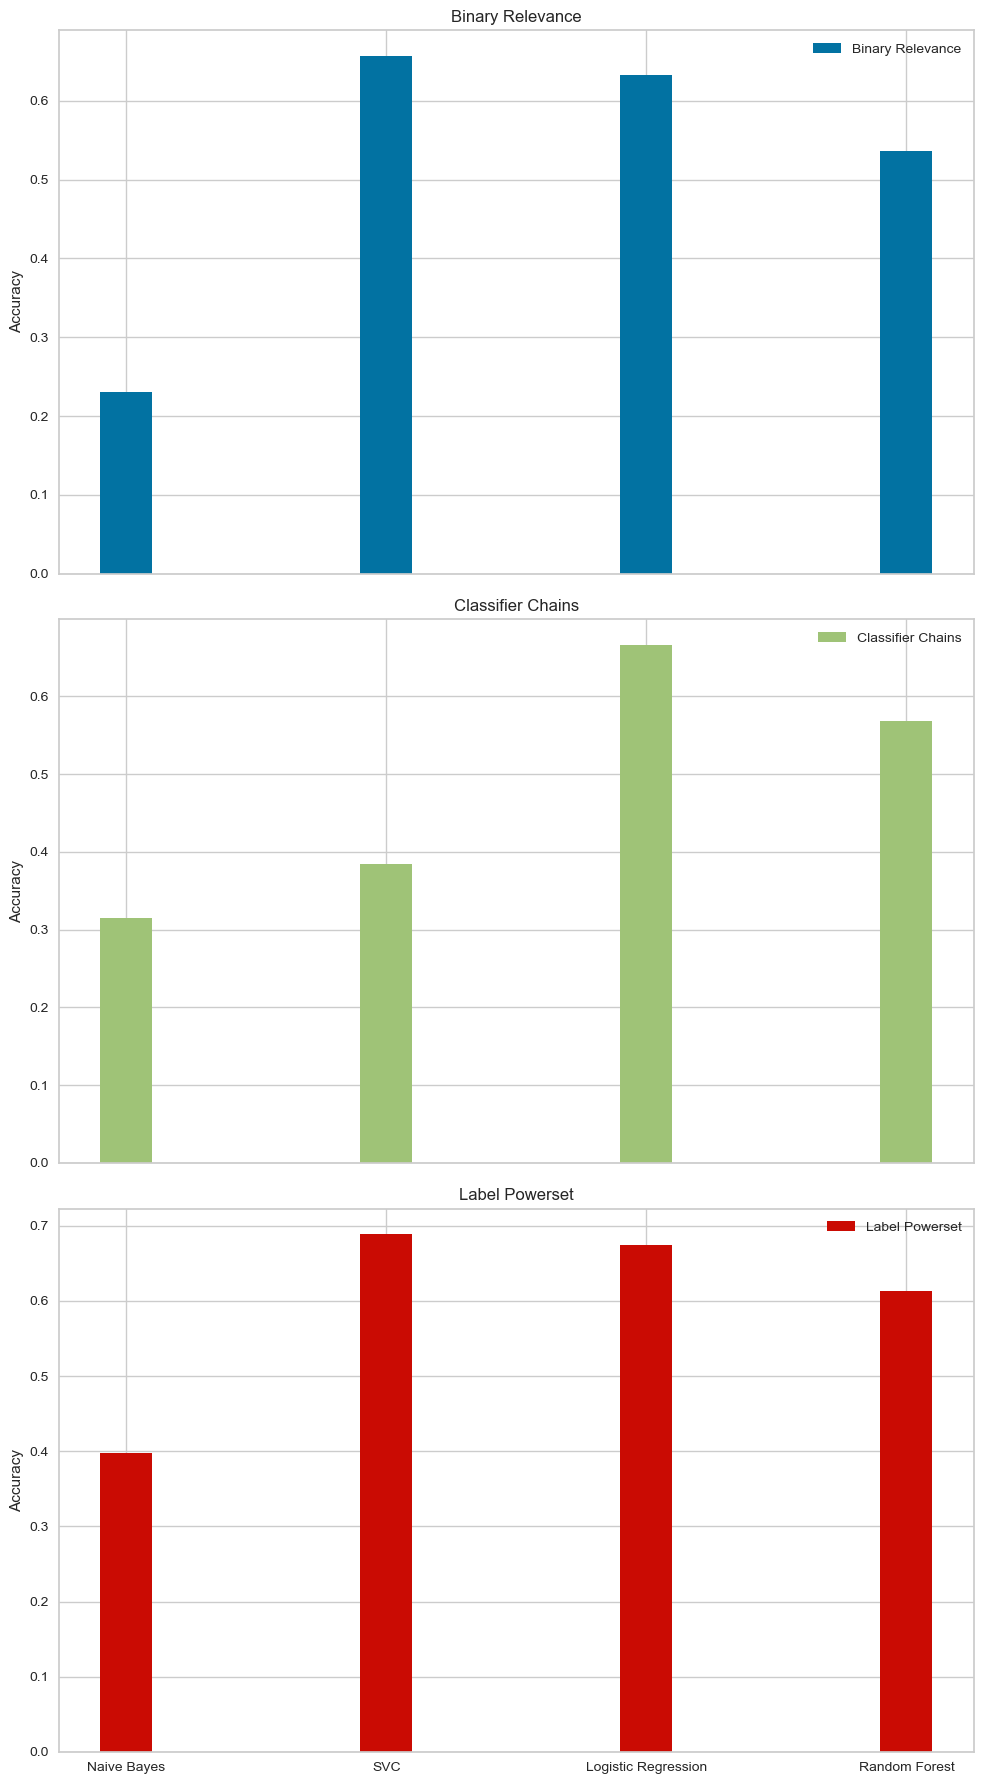

In [73]:
# Labels for classifiers
classifiers = ['Naive Bayes', 'SVC', 'Logistic Regression', 'Random Forest']

# X-axis locations for the groups
x = np.arange(len(classifiers))

# Width of a bar 
width = 0.2

# Plotting with 3 rows and 1 column
fig, axs = plt.subplots(3, 1, figsize=(10, 18), sharex=True)

# Binary Relevance
axs[0].bar(x, Accuracy_BR, width, label='Binary Relevance', color='b')
axs[0].set_title('Binary Relevance')
axs[0].set_xticks(x)
axs[0].set_xticklabels(classifiers)
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Classifier Chains
axs[1].bar(x, Accuracy_CC, width, label='Classifier Chains', color='g')
axs[1].set_title('Classifier Chains')
axs[1].set_xticks(x)
axs[1].set_xticklabels(classifiers)
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Label Powerset
axs[2].bar(x, Accuracy_LP, width, label='Label Powerset', color='r')
axs[2].set_title('Label Powerset')
axs[2].set_xticks(x)
axs[2].set_xticklabels(classifiers)
axs[2].set_ylabel('Accuracy')
axs[2].legend()

# Adding legends
for ax in axs:
    ax.legend()

plt.tight_layout()
plt.show()
